Dog Skin Disease Detection with ResNet

In [13]:
import os
import tensorflow as tf #tf 2.0.0
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [14]:
train_data_gen = ImageDataGenerator(rotation_range=50,
                                    width_shift_range=0.2,
                                    height_shift_range=0.2,
                                    zoom_range=0.3,
                                    horizontal_flip=True,
                                    vertical_flip=True,
                                    fill_mode='constant',
                                    cval=0,
                                    rescale=1./255)
valid_data_gen = ImageDataGenerator(rotation_range=45,
                                    width_shift_range=0.2,
                                    height_shift_range=0.2,
                                    zoom_range=0.3,
                                    horizontal_flip=True,
                                    vertical_flip=True,
                                    fill_mode='constant',
                                    cval=0,
                                    rescale=1./255)

test_data_gen = ImageDataGenerator(rescale=1./255)

In [15]:

dataset_dir = r'D:/IIT/Subjects/(4605)IRP/Devlo/DataSet'


Batch_size = 32
img_h = 128
img_w = 128
num_classes=4
classes = ['Healthy', # 0
           'Live_Wood', # 1
            'Pink_Wax', # 2
            'Stem_Canker', # 3
      
           ]
     

In [16]:
# Training
SEED = 1234
tf.random.set_seed(SEED) 

training_dir = os.path.join(dataset_dir, 'train')
train_gen = train_data_gen.flow_from_directory(training_dir,
                                               target_size=(128, 128),
                                               batch_size=Batch_size,
                                               classes=classes,
                                               class_mode='categorical',
                                               shuffle=True,
                                               seed=SEED)  # targets are directly converted into one-hot vectors

# Validation
valid_dir = os.path.join(dataset_dir, 'val')
valid_gen = valid_data_gen.flow_from_directory(valid_dir,
                                           target_size=(128, 128),
                                           batch_size=Batch_size, 
                                           classes=classes,
                                           class_mode='categorical',
                                           shuffle=False,
                                           seed=SEED)
# Test
test_dir = os.path.join(dataset_dir, 'test')
test_gen = test_data_gen.flow_from_directory(test_dir,
                                             target_size=(128, 128),
                                             batch_size=32, 
                                             shuffle=False,
                                             seed=SEED,
                                             class_mode=None,
                                             )


Found 0 images belonging to 4 classes.
Found 0 images belonging to 4 classes.


FileNotFoundError: [WinError 3] The system cannot find the path specified: 'D:/IIT/Subjects/(4605)IRP/Devlo/DataSet\\test'

Visualization data

In [20]:
CLASS_NAMES = np.array(['canine_scabies','fungal_infection','healthy','hypersensitivity_allergies'])

ResNet152V2 Model

In [5]:
ResNet_model = tf.keras.applications.ResNet152V2(weights='imagenet', include_top=False, input_shape=(img_h, img_w, 3))

In [ ]:
from tensorflow.keras import Model 
from tensorflow.keras.layers import Conv2D, Dense, MaxPooling2D, Dropout, Flatten,GlobalAveragePooling2D
from tensorflow.keras.models import Sequential

# The last 15 layers fine tune
for layer in ResNet_model.layers[:-15]:
    layer.trainable = False

x = ResNet_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(units=512, activation='relu')(x)
x = Dropout(0.3)(x)
x = Dense(units=512, activation='relu')(x)
x = Dropout(0.3)(x)
output  = Dense(units=4, activation='softmax')(x)
model = Model(ResNet_model.input, output)


model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 134, 134, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 64, 64, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 pool1_pad (ZeroPadding2D)      (None, 66, 66, 64)   0           ['conv1_conv[0][0]']         

In [7]:
loss = tf.keras.losses.CategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss=loss, metrics= ['accuracy'])

In [8]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

# Reduce learning rate when validation accuracy stops improving
lrr = ReduceLROnPlateau(
    monitor='val_accuracy', 
    patience=3, 
    verbose=1, 
    factor=0.4, 
    min_lr=0.0001
)

callbacks = [lrr]

# Using len() to get steps per epoch
STEP_SIZE_TRAIN = len(train_gen)  
STEP_SIZE_VALID = len(valid_gen)

# Use fit() instead of fit_generator()
transfer_learning_history = model.fit(
    train_gen,
    steps_per_epoch=STEP_SIZE_TRAIN,
    validation_data=valid_gen,
    validation_steps=STEP_SIZE_VALID,
    epochs=30,
    callbacks=callbacks
)


Epoch 1/30
55/55 [==============================] - 418s 7s/step - loss: 1.2486 - accuracy: 0.4701 - val_loss: 4.0621 - val_accuracy: 0.4750 - lr: 0.0010
Epoch 2/30
55/55 [==============================] - 399s 7s/step - loss: 1.0764 - accuracy: 0.5578 - val_loss: 1.9371 - val_accuracy: 0.4830 - lr: 0.0010
Epoch 3/30
55/55 [==============================] - 459s 8s/step - loss: 0.9833 - accuracy: 0.6084 - val_loss: 1.1528 - val_accuracy: 0.5609 - lr: 0.0010
Epoch 4/30
55/55 [==============================] - 471s 9s/step - loss: 0.9392 - accuracy: 0.6090 - val_loss: 1.2262 - val_accuracy: 0.5808 - lr: 0.0010
Epoch 5/30
55/55 [==============================] - 413s 8s/step - loss: 0.9225 - accuracy: 0.6323 - val_loss: 1.4438 - val_accuracy: 0.5709 - lr: 0.0010
Epoch 6/30
55/55 [==============================] - 406s 7s/step - loss: 0.8966 - accuracy: 0.6454 - val_loss: 1.2295 - val_accuracy: 0.5689 - lr: 0.0010
Epoch 7/30
55/55 [==============================] - 444s 8s/step - loss: 0.8

Visualization accuracy and loss

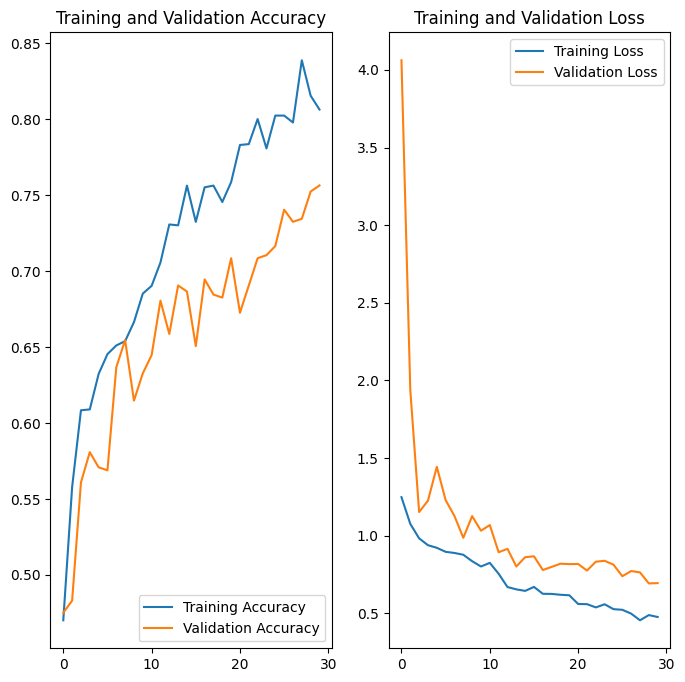

In [9]:
import matplotlib.pyplot as plt

acc = transfer_learning_history.history['accuracy']
val_acc = transfer_learning_history.history['val_accuracy']

loss = transfer_learning_history.history['loss']
val_loss = transfer_learning_history.history['val_loss']

epochs_range = range(30)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

model evaluate with validation set

In [10]:
model.evaluate(valid_gen, steps=STEP_SIZE_VALID,verbose=1)

16/16 [==============================] - 59s 4s/step - loss: 0.7689 - accuracy: 0.7345


[0.7688694596290588, 0.7345309257507324]

model prediction with test data

In [11]:
STEP_SIZE_TEST=test_gen.n//test_gen.batch_size
test_gen.reset()
pred=model.predict(test_gen,
steps=STEP_SIZE_TEST,
verbose=1)

7/7 [==============================] - 33s 4s/step


In [12]:
predicted_class_indices=np.argmax(pred,axis=1)